An initial attempt at a study justifying the number of iterations used for Uni-/MultiFold.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Generic imports
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

### ML imports
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import tensorflow as tf

### Custom functions
from omnifold import *
from omnifold.utilities import *

In [3]:
! nvidia-smi -L # list GPUs available

GPU 0: Tesla V100-PCIE-16GB (UUID: GPU-b2eedb47-e26d-4e8b-5f08-28bd60cb8c80)
GPU 1: Tesla V100-PCIE-16GB (UUID: GPU-330a175b-ca34-c7af-fff6-a665d8225488)
GPU 2: NVIDIA GeForce GT 710 (UUID: GPU-38820045-e66c-3d13-0512-e926ac5928ef)


In [8]:
# ### GPU Setup
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
plot_setup()
plt.rcParams.update({"font.family": "serif",})

In [5]:
plot_dir = './plots/'

### Load files

Since we're not using data yet, "MC" = Powheg + Pythia8 MC16e and "data" = Sherpa 2.2.1 MC16e.

In [6]:
folder = '/data0/mpettee/omnifold_data/'

In [7]:
f_mc = uproot.open(folder+"ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root")
f_data = uproot.open(folder+"ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root")

In [8]:
columns = f_mc['OmniTree'].keys()

These columns are the same for both samples, since they're both MC:

In [9]:
f_mc['OmniTree'].keys() == f_data['OmniTree'].keys()

True

Note that variables ending in `_tracks` require MultiIndex-ing. It's possible to combine these with flat variables, but it does increase the size of the DataFrame considerably: 

In [16]:
# [col for col in columns if col.endswith("_tracks")]

In [17]:
# f_mc['OmniTree'].arrays(
#     ["weight","pT_tracks"],
#     library="pd")

Let's ignore the MultiIndex variables for now.

In [10]:
mc = f_mc['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

data = f_data['OmniTree'].arrays(
    [col for col in columns if not col.endswith("_tracks")],
    library="pd")

print("MC has {:,} events with {} columns.".format(mc.shape[0],mc.shape[1]))
print("Data has {:,} events with {} columns.".format(data.shape[0],data.shape[1]))

MC has 416,725 events with 57 columns.
Data has 3,578,623 events with 57 columns.


### Apply event selection

In [11]:
mc['pass190'] = mc['pass190'].astype('bool')
mc['truth_pass190'] = mc['truth_pass190'].astype('bool')
data['pass190'] = data['pass190'].astype('bool')
data['truth_pass190'] = data['truth_pass190'].astype('bool')

In [12]:
### The sample we're using already has these cuts applied, but we'll keep them in for future datasets. 
mc_truth_weights = mc[(mc.pass190 | mc.truth_pass190)].weight_mc
mc_reco_weights = mc[(mc.pass190 | mc.truth_pass190)].weight

data_truth_weights = data[data.truth_pass190].weight_mc
data_reco_weights = data[data.pass190].weight

In [13]:
## JUST FOR FUN/OPTIONAL: add a large offset to 10% of the true data, for fun
# data_truth_weights[:343775] = data_truth_weights[:343775]*10

Normalize the weights:

In [14]:
for weights in [mc_truth_weights, mc_reco_weights, data_truth_weights, data_reco_weights]:
    weights /= np.mean(weights)

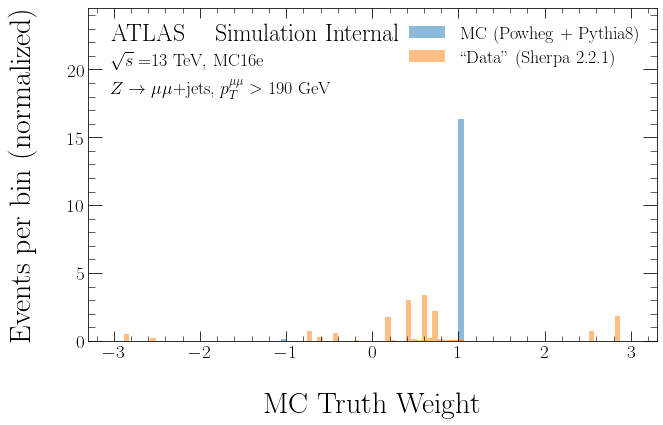

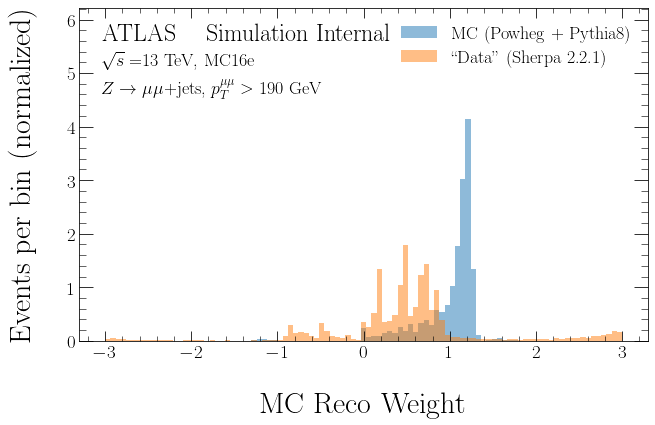

In [15]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(mc_truth_weights,
                              bins=bins,
                              label=r'MC (Powheg + Pythia8)',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights,
                               bins=bins,
                               label=r'``Data" (Sherpa 2.2.1)',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(mc_reco_weights,
                             bins=bins,
                             label=r'MC (Powheg + Pythia8)',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights,
                              bins=bins,
                              label=r'``Data" (Sherpa 2.2.1)',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()

### Load IBU histograms to get binning

In [16]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]
plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [17]:
IBU_hists = uproot.open(folder+'unfoldingPlotsJune14_UnfoldedHists.root')

bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [18]:
labels_and_bins = zip(file_labels, plot_labels, bins)

ibu_hists = []

for file_label, plot_label, plot_bins in labels_and_bins:
    ibu_hists += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

### Unifold

In [19]:
K.clear_session()
unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))

In [20]:
save_label0 = 'test'

In [21]:
i = 0 # index of variable of interest (num_tracks for leading jet)
### Replace bins with Laura's new binning! 
ibu_hists[i]['bins'] = np.array([1,  7,  11,  15,  20,  30,  40]) 
bins = ibu_hists[i]['bins']
x_label = ibu_hists[i]['plot_label']
file_label = ibu_hists[i]['file_label']
os.makedirs(plot_dir+'UniFold/'+file_label, exist_ok=True)
save_label = plot_dir+'UniFold/'+file_label+'/'+save_label0
print("Saving as {}.".format(save_label))

Saving as ./plots/UniFold/Ntracks_trackj1/test.


Grab the particular variable you care about, and set a dummy value for events that don't pass each MC selection:

In [22]:
dummyval = -99
mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
mc_truth[mc.truth_pass190 == False] = dummyval
mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
mc_reco[mc.pass190 == False] = dummyval

data_truth = data[data['truth_pass190']]['truth_' + file_label]
data_reco = data[data['pass190']][file_label]

Plot this observable in MC & "data" before unfolding:

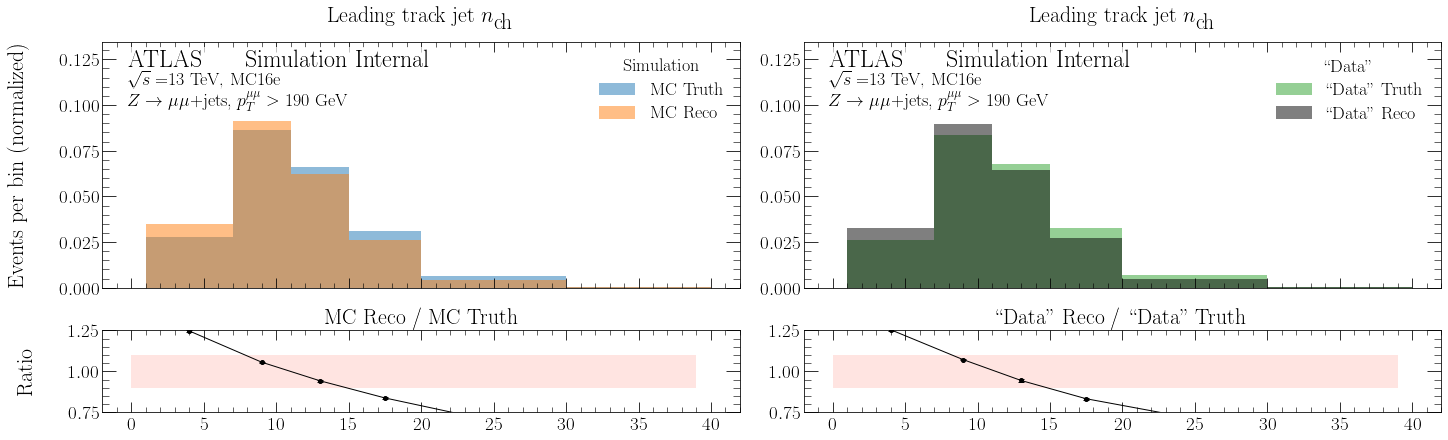

In [23]:
plot_distributions(
    sim_truth=mc_truth,
    sim_reco=mc_reco,
    sim_truth_weights_MC=mc_truth_weights,
    sim_reco_weights_MC=mc_reco_weights,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights,
    data_reco_weights_MC=data_reco_weights,
    bins=bins,
    x_label=x_label,
    save_label=save_label
)

Standardize the data by z-score:

In [24]:
mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), np.array(mc_reco), np.array(data_reco))

Unfold!

In [25]:
weights, _ = unifold(iterations=3,
                     sim_truth=mc_truth_z,
                     sim_reco=mc_reco_z,
                     sim_truth_weights_MC=mc_truth_weights,
                     sim_reco_weights_MC=mc_reco_weights,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights,
                     dummyval=dummyval,
                     verbose=0,
                    )

  0%|          | 0/3 [00:00<?, ?it/s]/home/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)
100%|██████████| 3/3 [02:34<00:00, 51.59s/it]


In [26]:
unifold_weights[i] = best_1D_reweighting(
    test=mc_reco,
    test_weights=np.array(mc_reco_weights) * weights[:,1],
    target=data_reco,
    target_weights=data_reco_weights,
    bins=bins)

100%|██████████| 4/4 [00:11<00:00,  2.87s/it]
/home/mpettee/ATLASOmniFold/omnifold/plot.py:500: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if save_label is not None:


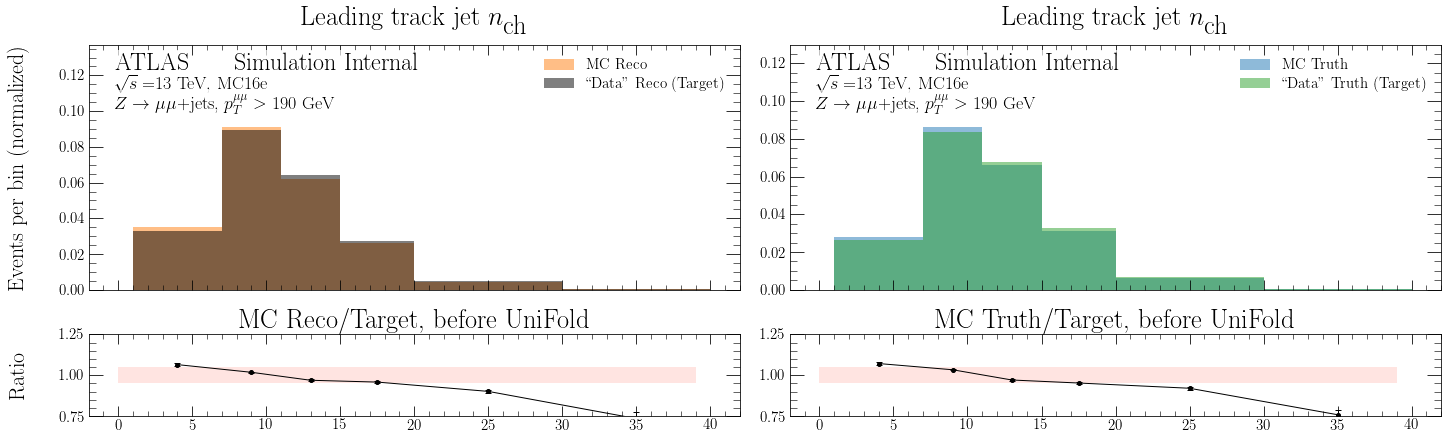

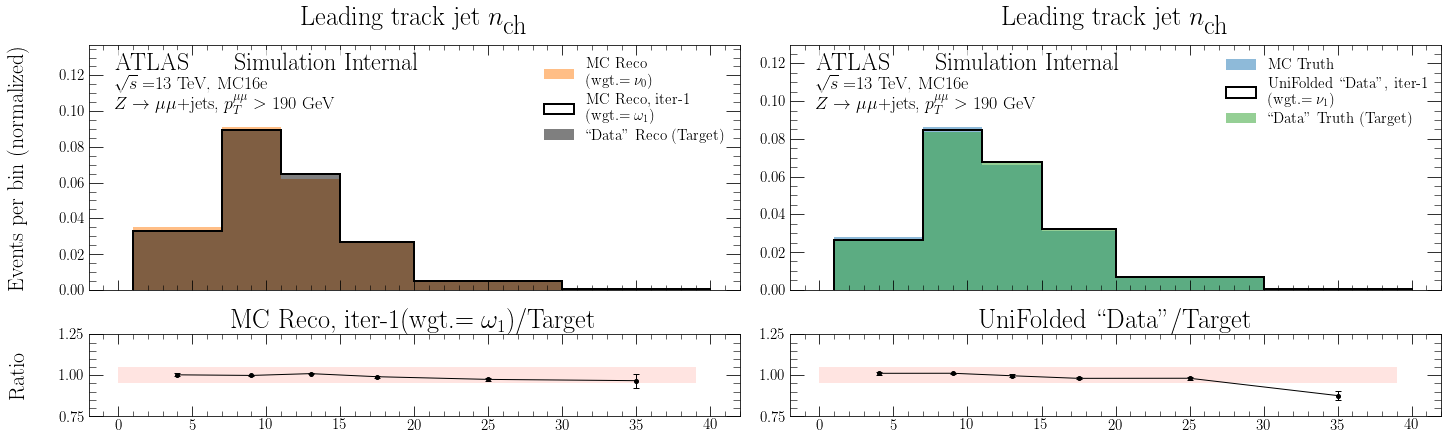

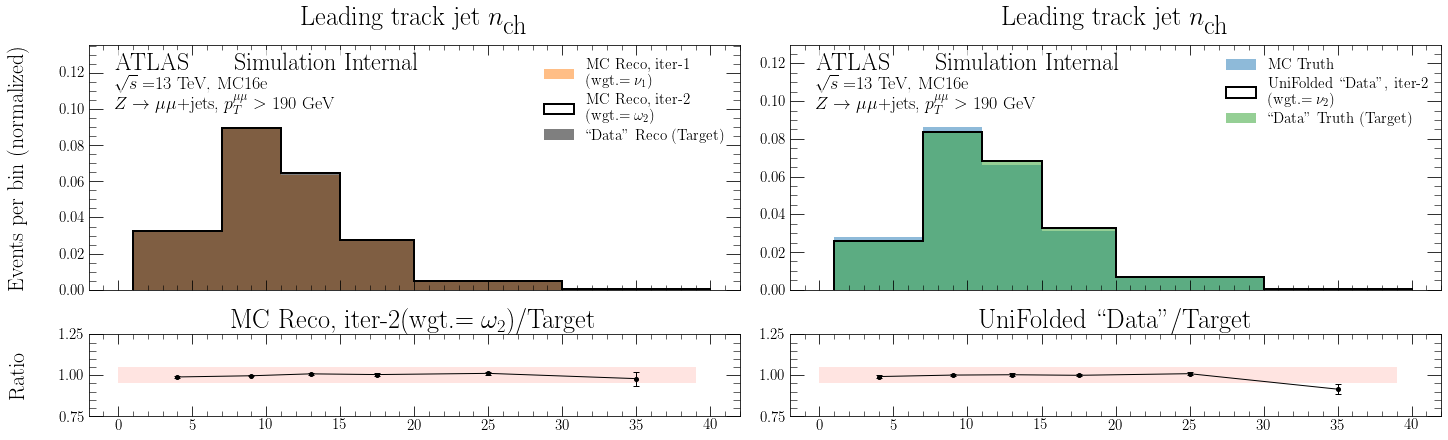

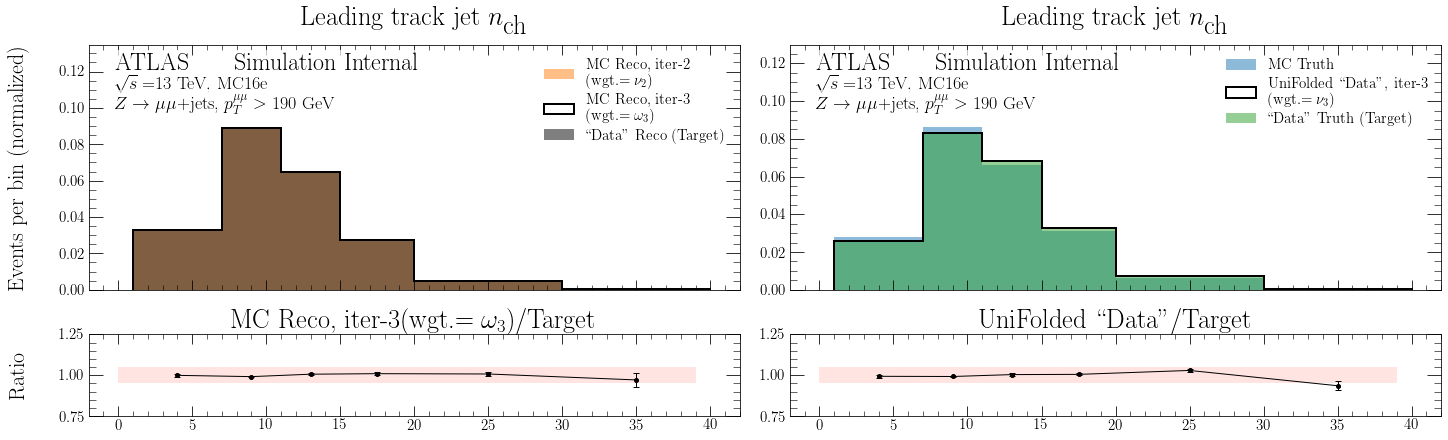

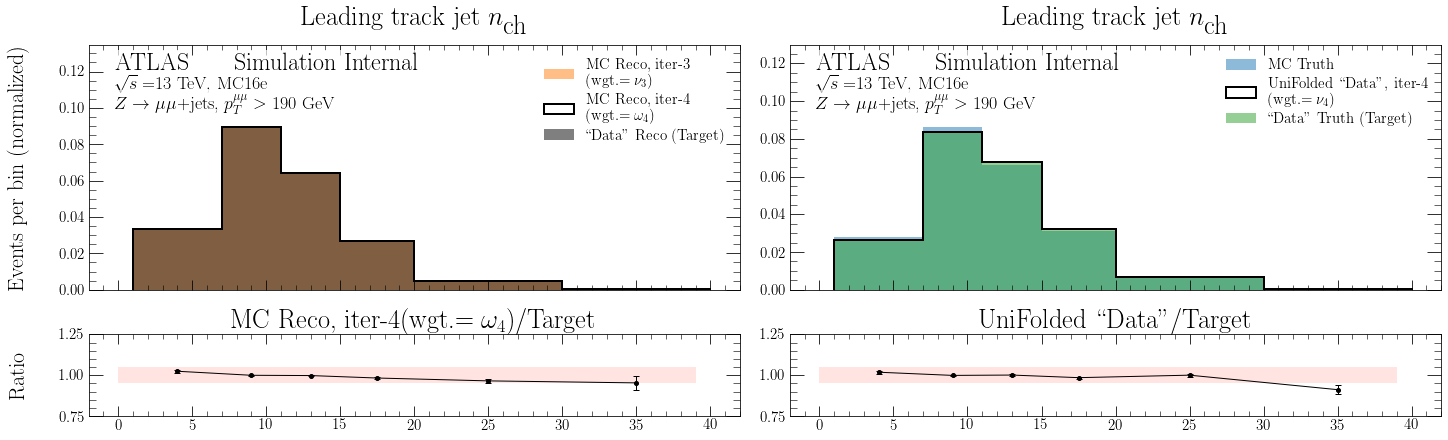

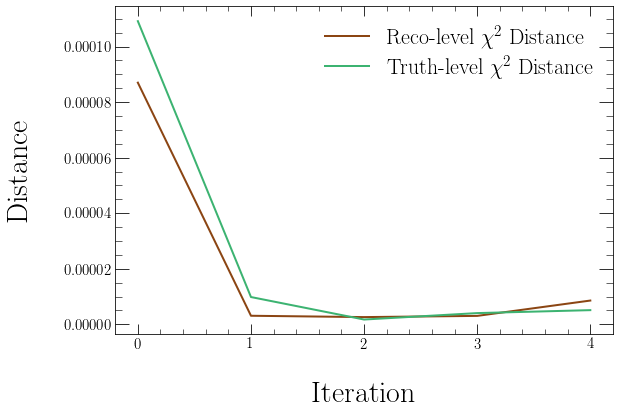

In [39]:
plot_results(sim_truth=mc_truth,
             sim_reco=mc_reco,
             sim_truth_weights_MC=mc_truth_weights,
             sim_reco_weights_MC=mc_reco_weights,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights,
             data_reco_weights_MC=data_reco_weights,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label
            )

### Run unfolding multiple times w/ Poisson bootstrapping to calculate statistical uncertainty:

In [ ]:
n_trials = 2        # how many full runs of unfolding     #30
n_iterations = 3    # how many iterations per unfolding process    #10

# Unifold result
reco_unfolded_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1)) 
truth_unfolded_hists = np.zeros((n_trials, n_iterations+1, len(bins)-1))

# Chi-squared distances
reco_distances = np.zeros((n_trials, n_iterations+1, len(bins)-1)) 
truth_distances = np.zeros((n_trials, n_iterations+1, len(bins)-1))

for i in tqdm(range(n_trials), desc="Trial"):
    
    K.clear_session()
    unifold_weights = np.zeros(shape=(len(ibu_hists), len(mc_truth_weights)))
    var_i = 0 # index of variable of interest (num_tracks for leading jet)
    bins = ibu_hists[var_i]['bins']
    x_label = ibu_hists[var_i]['plot_label']
    file_label = ibu_hists[var_i]['file_label']
    
    dummyval = -99
    mc_truth = mc[(mc.pass190 | mc.truth_pass190)]['truth_' + file_label]
    mc_truth[mc.truth_pass190 == False] = dummyval
    mc_reco = mc[(mc.pass190 | mc.truth_pass190)][file_label]
    mc_reco[mc.pass190 == False] = dummyval

    data_truth = data[data['truth_pass190']]['truth_' + file_label]
    data_reco = data[data['pass190']][file_label]

    # z-score standardization of data
    mc_truth_z, mc_reco_z, data_reco_z = standardize(np.array(mc_truth), 
                                                   np.array(mc_reco),
                                                   np.array(data_reco))
    
    ### Fill these arrays for Iteration 0, i.e. before unfolding, for context

    hR0, _ = np.histogram(mc_reco[mc_reco!=dummyval],
                       weights=mc_reco_weights[mc_reco!=dummyval],
                       bins=bins, density=True)
    
    hR2, _ = np.histogram(data_reco[data_reco!=dummyval],
                       weights=data_reco_weights[data_reco!=dummyval],
                       bins=bins, density=True)
    
    hT0, _ = np.histogram(mc_truth[mc_truth!=dummyval],
                       weights=mc_truth_weights[mc_truth!=dummyval],
                       bins=bins, density=True)
    
    hT2, _ = np.histogram(data_truth[data_truth!=dummyval],
                       weights=data_truth_weights[data_truth!=dummyval],
                       bins=bins, density=True)
    
    
    reco_distances[i][0] = 0.5*np.sum((hR0-hR2)**2/(hR0+hR2))
    truth_distances[i][0] = 0.5*np.sum((hT0-hT2)**2/(hT0+hT2))
        
    reco_unfolded_hists[i][0] = hR0
    truth_unfolded_hists[i][0] = hT0
    
    ### Reweight using Poisson distribution with λ=1 (new distribution for each iteration)
    mc_reco_weights = mc_reco_weights*np.random.poisson(lam=1.0, size=(len(mc_reco_weights)))
    mc_truth_weights = mc_truth_weights*np.random.poisson(lam=1.0, size=(len(mc_truth_weights)))
    
    ### Perform all iterations of unfolding, and fill results in "weights" array
    weights, _ = unifold(iterations=n_iterations,
                 sim_truth=mc_truth_z,
                 sim_reco=mc_reco_z,
                 sim_truth_weights_MC=mc_truth_weights,
                 sim_reco_weights_MC=mc_reco_weights,
                 data_reco=data_reco_z,
                 data_reco_weights_MC=data_reco_weights,
                 dummyval=dummyval,
                 verbose=0,
                )

    ### Fill arrays evaluating each iteration
    for j in np.arange(n_iterations):
        hR1, _ = np.histogram(mc_reco[mc_reco!=dummyval],
                               weights=(mc_reco_weights * weights[j, 0, :])[mc_reco!=dummyval],
                               bins=bins,density=True)
        hR2, _ = np.histogram(data_reco[data_reco!=dummyval],
                               weights=data_reco_weights[data_reco!=dummyval],
                               bins=bins,density=True)
        reco_distances[i][j+1] = 0.5*np.sum((hR1-hR2)**2/(hR1+hR2))
        reco_unfolded_hists[i][j+1] = hR1
        
        hT1, _ = np.histogram(mc_truth[mc_truth!=dummyval],
                           weights=(mc_truth_weights * weights[j, 1, :])[mc_truth!=dummyval],
                           bins=bins,density=True)
        if data_truth is not None:
            hT2, _ = np.histogram(data_truth[data_truth!=dummyval],
                               weights=data_truth_weights[data_truth!=dummyval],
                               bins=bins,density=True)
        truth_distances[i][j+1] = 0.5*np.sum((hT1-hT2)**2/(hT1+hT2))
        truth_unfolded_hists[i][j+1] = hT1

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
reco_unfolded_hists.shape # (n_trials, n_iterations+1, n_bins)

In [ ]:
mean_reco_distances = np.mean(reco_distances, axis=(0,2))
mean_truth_distances = np.mean(truth_distances, axis=(0,2))
reco_stat_uncert = np.mean(np.var(reco_unfolded_hists, axis=0), axis=1)
truth_stat_uncert = np.mean(np.var(truth_unfolded_hists, axis=0), axis=1)

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,6), constrained_layout=True)
ax = axs[0]
ax.plot(np.arange(len(weights)+1), mean_reco_distances, label=r"Reco-level $\chi^2$ Distance", linewidth=2, color="saddlebrown")
ax.plot(np.arange(len(weights)+1), mean_truth_distances, label=r"Truth-level $\chi^2$ Distance", linewidth=2, color="mediumseagreen")
ax.set_xlabel("Iteration")
ax.set_ylabel("Average Distance")
ax.legend(fontsize=22)

ax = axs[1]
ax.plot(np.arange(len(weights)+1), reco_stat_uncert, label=r"Reco-level $\sigma$", linewidth=2, color="saddlebrown")
ax.plot(np.arange(len(weights)+1), truth_stat_uncert, label=r"Truth-level $\sigma$", linewidth=2, color="mediumseagreen")
ax.set_xlabel("Iteration")
ax.set_ylabel("Average Stat. Uncertainty")
ax.legend(fontsize=22)

if save_label is not None:
    fig.savefig(save_label + '-distances-and-uncert.png',
                bbox_inches='tight',
                dpi=100)